### Enviromment

In [5]:
!pip install neuromaps
!pip install shap
!pip install netneurotools
!pip install nibabel ply
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not install packages due to an OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /etc/pki/tls/certs/ca-bundle.crt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: Could not install packages due to an OSError: Could not find a suitable TLS CA certificate bundle, invalid path: /etc/pki/tls/certs/ca-bundle.crt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)
ERROR: Could not install packages due to an OSError: [Errno 38] Function not implemented: '/op

In [7]:
# Import necessary libraries
from neuromaps import datasets, transforms, plotting, parcellate
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
#from netneurotools import datasets as nntdata
import nibabel as nib
import nilearn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import json
import re

import lightgbm as lgbm
from sklearn.model_selection import cross_val_score
import shap

ModuleNotFoundError: No module named 'lightgbm'

In [5]:
pd.set_option('display.max_colwidth', None)


### Data

In [12]:
with open('/home/tamires/projects/rpp-aevans-ab/tamires/data_science_neuroimage/meta.json', 'r') as file:
    data = json.load(file)
data

{'annotations': [{'annot': {'source': 'abagen',
    'desc': 'genepc1',
    'space': 'fsaverage',
    'den': '10k'},
   'full_desc': 'PC1 of genes in the Allen Human Brain Atlas',
   'refs': {'primary': [{'citation': 'Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.',
      'bibkey': 'hawrylycz2012nature'},
     {'citation': 'Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.',
      'bibkey': 'markello2021elife'}],
    'secondary': [{'citation': '', 'bibkey': ''}]},
   'demographics': {'N': 6, 'age': '24-55'}},
  {'annot': {'source': 'aghourian2017',
    'desc': 'feobv',
    'space': '

In [13]:
def extract_fields(annotation):
    return pd.Series([annotation['source'], annotation['desc'], annotation['space'], annotation.get('res', annotation.get('den', None))],
                     index=['source', 'desc', 'space', 'res/den'])

df = pd.DataFrame(data['annotations']).drop(columns=['refs','warning','license'])
new_columns = df['annot'].apply(extract_fields)
df = pd.concat([df, new_columns], axis=1).drop(columns=['annot'])
df

,full_desc,demographics,source,desc,space,res/den
0,PC1 of genes in the Allen Human Brain Atlas,"{'N': 6, 'age': '24-55'}",abagen,genepc1,fsaverage,10k
1,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 18, 'age': '66.8 +/- 6.8'}",aghourian2017,feobv,MNI152,1mm
2,PET tracer binding (BPnd) to D2 (dopamine rece...,"{'N': 7, 'age': '24 +/- 2'}",alarkurtti2015,raclopride,MNI152,3mm
3,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 5, 'age': '68.3 +/- 3.1'}",bedard2019,feobv,MNI152,1mm
4,PET tracer binding (Bmax) to 5-HT1b (serotonin...,"{'N': 36, 'age': '27.8 +/- 6.9'}",beliveau2017,az10419369,MNI152,1mm
...,...,...,...,...,...,...
82,PET tracer binding (BPnd) to MOR (mu-opioid re...,"{'N': 39, 'age': '39.38 +/- 5.05'}",turtonen2020,carfentanil,MNI152,1mm
83,PET tracer binding (Vt) to KOR (kappa-opioid r...,"{'N': 28, 'age': '33.5 +/- 11.3'}",vijay2018,ly2795050,MNI152,2mm
84,PET tracer binding (SUVR) to class 1 HDAC isof...,"{'N': 8, 'age': '28.6 +/- 7.6'}",wey2016,martinostat,MNI152,2mm
85,Cross-species functional homology,"{'N': None, 'age': None}",xu2020,FChomology,fsLR,32k


In [14]:
for tag in datasets.available_tags():
  desc_tag = [t[1] for t in datasets.available_annotations(tags=[tag])]
  df[tag] = np.where(df['desc'].isin(desc_tag), 1, 0)
  df['desc_source'] = df['desc'] + '_' + df['source']
df

,full_desc,demographics,source,desc,space,res/den,ASL,desc_source,MEG,MRI,PET,fMRI,functional,genetics,meta-analysis,metabolism,receptors,resteyesopen,structural
0,PC1 of genes in the Allen Human Brain Atlas,"{'N': 6, 'age': '24-55'}",abagen,genepc1,fsaverage,10k,0,genepc1_abagen,0,0,0,0,0,1,0,0,0,0,0
1,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 18, 'age': '66.8 +/- 6.8'}",aghourian2017,feobv,MNI152,1mm,0,feobv_aghourian2017,0,0,1,0,0,0,0,0,1,0,0
2,PET tracer binding (BPnd) to D2 (dopamine rece...,"{'N': 7, 'age': '24 +/- 2'}",alarkurtti2015,raclopride,MNI152,3mm,0,raclopride_alarkurtti2015,0,0,1,0,0,0,0,0,1,0,0
3,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 5, 'age': '68.3 +/- 3.1'}",bedard2019,feobv,MNI152,1mm,0,feobv_bedard2019,0,0,1,0,0,0,0,0,1,0,0
4,PET tracer binding (Bmax) to 5-HT1b (serotonin...,"{'N': 36, 'age': '27.8 +/- 6.9'}",beliveau2017,az10419369,MNI152,1mm,0,az10419369_beliveau2017,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,PET tracer binding (BPnd) to MOR (mu-opioid re...,"{'N': 39, 'age': '39.38 +/- 5.05'}",turtonen2020,carfentanil,MNI152,1mm,0,carfentanil_turtonen2020,0,0,1,0,0,0,0,0,1,0,0
83,PET tracer binding (Vt) to KOR (kappa-opioid r...,"{'N': 28, 'age': '33.5 +/- 11.3'}",vijay2018,ly2795050,MNI152,2mm,0,ly2795050_vijay2018,0,0,1,0,0,0,0,0,1,0,0
84,PET tracer binding (SUVR) to class 1 HDAC isof...,"{'N': 8, 'age': '28.6 +/- 7.6'}",wey2016,martinostat,MNI152,2mm,0,martinostat_wey2016,0,0,0,0,0,0,0,0,0,0,0
85,Cross-species functional homology,"{'N': None, 'age': None}",xu2020,FChomology,fsLR,32k,0,FChomology_xu2020,0,1,0,0,1,0,0,0,0,0,0


In [15]:
names_features_adjusted = {
 'thickness_hcps1200': 'thickness_hcps1200',
 'feobv_aghourian2017': 'VAChT_acetylcholine_transporter_aghourian2017',
 'raclopride_alarkurtti2015': 'D2_dopamine_receptor_alarkurtti2015',
 'feobv_bedard2019': 'VAChT_acetylcholine_transporter_bedard2019',
 'mrb_ding2010': 'NET_norepinephrine_transporter_ding2010',
 'abp688_dubois2015': 'mGluR5_glutamate_receptor_dubois2015)',
 'flumazenil_dukart2018': 'GABAa_gaba_receptor_dukart2018',
 'fpcit_dukart2018': 'DAT_dopamine_transporter_dukart2018',
 'madam_fazio2016': '5HTT_serotonin_transporter_fazio2016',
 'ucbj_finnema2016': 'SV2A_synapse_marker_2016',
 'p943_gallezot2010': '5HT1b_serotonin_receptor_gallezot2010',
 'gsk189254_gallezot2017': 'H3_histamine_receptor_gallezot2017',
 'myelinmap_hcps1200': 'myelinmap_hcps1200',
 'methylreboxetine_hesse2017': 'NET_norepinephrine_transporter_hesse2017',
 'flubatine_hillmer2016': 'a4b2_acetylcholine_receptor_hillmer2016',
 'fallypride_jaworska2020': 'D2_dopamine_receptor_jaworska2020',
 'sch23390_kaller2017': 'D1_dopamine_receptor_kaller2017',
 'carfentanil_kantonen2020': 'MOR_mu_opioid_receptor_kantonen2020',
 'fmpepd2_laurikainen2018': 'CB1_cannabinoid_receptor_laurikainen2018',
 'fcgradient01_margulies2016': 'fcgradient01_margulies2016',
 'fcgradient02_margulies2016': 'fcgradient02_margulies2016',
 'fcgradient03_margulies2016': 'fcgradient03_margulies2016',
 'fcgradient04_margulies2016': 'fcgradient04_margulies2016',
 'fcgradient05_margulies2016': 'fcgradient05_margulies2016',
 'fcgradient06_margulies2016': 'fcgradient06_margulies2016',
 'fcgradient07_margulies2016': 'fcgradient07_margulies2016',
 'fcgradient08_margulies2016': 'fcgradient08_margulies2016',
 'fcgradient09_margulies2016': 'fcgradient09_margulies2016',
 'fcgradient10_margulies2016': 'fcgradient10_margulies2016',
 'lsn3172176_naganawa2020': 'M1_acetylcholine_receptor_naganawa2020',
 'cogpc1_neurosynth': 'cogpc1_neurosynth',
 'omar_normandin2015': 'CB1_cannabinoid_receptor_normandin2015',
 'gsk215083_radnakrishnan2018': '5HT6_serotonin_receptor_radnakrishnan2018',
 'abp688_rosaneto': 'mGluR5_glutamate_receptor_rosaneto',
 'flb457_sandiego2015': 'D2_dopamine_receptor_sandiego2015',
 'fepe2i_sasaki2012': 'DAT_dopamine_transporter_sasaki2012',
 'meancbf_satterthwaite2014': 'blood_flow_satterthwaite2014',
 'altanserin_savli2012': '5HT2a_serotonin_receptor_savli2012',
 'dasb_savli2012': '5HTT_serotonin_transporter_savli2012',
 'p943_savli2012': '5HT1b_serotonin_receptor_savli2012',
 'way100635_savli2012': '5HT1a_serotonin receptor_savli2012',
 'abp688_smart2019': 'mGluR5_glutamate_receptor_smart2019',
 'flb457_smith2017': 'dopamine_receptor_smith2017',
 'SAaxis_sydnor2021': 'sensory_association_sydnor2021',
 'feobv_tuominen': 'VAChT_acetylcholine_transporter_tuominen',
 'carfentanil_turtonen2020': 'MOR_mu_opioid_receptor_turtonen2020',
 'ly2795050_vijay2018': 'KOR_kappa_opioid_receptor_vijay2018',
 'FChomology_xu2020': 'cross_species_functional_homology_xu2020',
 'evoexp_xu2020': 'evolutionary_cortical_expansion_xu2020'}

group = {
 'cogpc1_neurosynth': 'Functional information (fMRI)',
 'thickness_hcps1200': 'Structural information (MRI)',
 'feobv_aghourian2017': 'Neurotransmitter information (PET)',
 'raclopride_alarkurtti2015': 'Neurotransmitter information (PET)',
 'feobv_bedard2019': 'Neurotransmitter information (PET)',
 'mrb_ding2010': 'Neurotransmitter information (PET)',
 'abp688_dubois2015': 'Neurotransmitter information (PET)',
 'flumazenil_dukart2018': 'Neurotransmitter information (PET)',
 'fpcit_dukart2018': 'Neurotransmitter information (PET)',
 'madam_fazio2016': 'Neurotransmitter information (PET)',
 'ucbj_finnema2016': 'Neurotransmitter information (PET)',
 'p943_gallezot2010': 'Neurotransmitter information (PET)',
 'gsk189254_gallezot2017': 'Neurotransmitter information (PET)',
 'myelinmap_hcps1200': 'Structural information (MRI)',
 'methylreboxetine_hesse2017': 'Neurotransmitter information (PET)',
 'flubatine_hillmer2016': 'Neurotransmitter information (PET)',
 'fallypride_jaworska2020': 'Neurotransmitter information (PET)',
 'sch23390_kaller2017': 'Neurotransmitter information (PET)',
 'carfentanil_kantonen2020': 'Neurotransmitter information (PET)',
 'fmpepd2_laurikainen2018': 'Neurotransmitter information (PET)',
 'fcgradient01_margulies2016': 'Functional information (fMRI)',
 'fcgradient02_margulies2016': 'Functional information (fMRI)',
 'fcgradient03_margulies2016': 'Functional information (fMRI)',
 'fcgradient04_margulies2016': 'Functional information (fMRI)',
 'fcgradient05_margulies2016': 'Functional information (fMRI)',
 'fcgradient06_margulies2016': 'Functional information (fMRI)',
 'fcgradient07_margulies2016': 'Functional information (fMRI)',
 'fcgradient08_margulies2016': 'Functional information (fMRI)',
 'fcgradient09_margulies2016': 'Functional information (fMRI)',
 'fcgradient10_margulies2016': 'Functional information (fMRI)',
 'lsn3172176_naganawa2020': 'Neurotransmitter information (PET)',
 'omar_normandin2015': 'Neurotransmitter information (PET)',
 'gsk215083_radnakrishnan2018': 'Neurotransmitter information (PET)',
 'abp688_rosaneto': 'Neurotransmitter information (PET)',
 'flb457_sandiego2015': 'Neurotransmitter information (PET)',
 'fepe2i_sasaki2012': 'Neurotransmitter information (PET)',
 'meancbf_satterthwaite2014': 'Blood Flow (ASL)',
 'altanserin_savli2012': 'Neurotransmitter information (PET)',
 'dasb_savli2012': 'Neurotransmitter information (PET)',
 'p943_savli2012': 'Neurotransmitter information (PET)',
 'way100635_savli2012': 'Neurotransmitter information (PET)',
 'abp688_smart2019': 'Neurotransmitter information (PET)',
 'flb457_smith2017': 'Neurotransmitter information (PET)',
 'SAaxis_sydnor2021': 'Functional information (fMRI)',
 'feobv_tuominen': 'Neurotransmitter information (PET)',
 'carfentanil_turtonen2020': 'Neurotransmitter information (PET)',
 'ly2795050_vijay2018': 'Neurotransmitter information (PET)',
 'evoexp_xu2020': 'Structural information (MRI)'
 }

colors = {
    'Structural information (MRI)': '#b77cc3',
    'Neurotransmitter information (PET)':  '#f66ba1',
    'Functional information (fMRI)': '#f6b29b',
    'Blood Flow (ASL)': '#6f78dc',
    'np.nan':'#444444'
}

df['name'] = df['desc_source'].map(names_features_adjusted)
df['group'] = df['desc_source'].map(group)
df['color'] = df['group'].map(colors)
df

,full_desc,demographics,source,desc,space,res/den,ASL,desc_source,MEG,MRI,...,functional,genetics,meta-analysis,metabolism,receptors,resteyesopen,structural,name,group,color
0,PC1 of genes in the Allen Human Brain Atlas,"{'N': 6, 'age': '24-55'}",abagen,genepc1,fsaverage,10k,0,genepc1_abagen,0,0,...,0,1,0,0,0,0,0,NaN,NaN,NaN
1,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 18, 'age': '66.8 +/- 6.8'}",aghourian2017,feobv,MNI152,1mm,0,feobv_aghourian2017,0,0,...,0,0,0,0,1,0,0,VAChT_acetylcholine_transporter_aghourian2017,Neurotransmitter information (PET),#f66ba1
2,PET tracer binding (BPnd) to D2 (dopamine rece...,"{'N': 7, 'age': '24 +/- 2'}",alarkurtti2015,raclopride,MNI152,3mm,0,raclopride_alarkurtti2015,0,0,...,0,0,0,0,1,0,0,D2_dopamine_receptor_alarkurtti2015,Neurotransmitter information (PET),#f66ba1
3,PET tracer binding (SUVR) to VAChT (acetylchol...,"{'N': 5, 'age': '68.3 +/- 3.1'}",bedard2019,feobv,MNI152,1mm,0,feobv_bedard2019,0,0,...,0,0,0,0,1,0,0,VAChT_acetylcholine_transporter_bedard2019,Neurotransmitter information (PET),#f66ba1
4,PET tracer binding (Bmax) to 5-HT1b (serotonin...,"{'N': 36, 'age': '27.8 +/- 6.9'}",beliveau2017,az10419369,MNI152,1mm,0,az10419369_beliveau2017,0,0,...,0,0,0,0,1,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,PET tracer binding (BPnd) to MOR (mu-opioid re...,"{'N': 39, 'age': '39.38 +/- 5.05'}",turtonen2020,carfentanil,MNI152,1mm,0,carfentanil_turtonen2020,0,0,...,0,0,0,0,1,0,0,MOR_mu_opioid_receptor_turtonen2020,Neurotransmitter information (PET),#f66ba1
83,PET tracer binding (Vt) to KOR (kappa-opioid r...,"{'N': 28, 'age': '33.5 +/- 11.3'}",vijay2018,ly2795050,MNI152,2mm,0,ly2795050_vijay2018,0,0,...,0,0,0,0,1,0,0,KOR_kappa_opioid_receptor_vijay2018,Neurotransmitter information (PET),#f66ba1
84,PET tracer binding (SUVR) to class 1 HDAC isof...,"{'N': 8, 'age': '28.6 +/- 7.6'}",wey2016,martinostat,MNI152,2mm,0,martinostat_wey2016,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
85,Cross-species functional homology,"{'N': None, 'age': None}",xu2020,FChomology,fsLR,32k,0,FChomology_xu2020,0,1,...,1,0,0,0,0,0,0,cross_species_functional_homology_xu2020,NaN,NaN


### Preprocessing

In [16]:
base_full_desc = 'MRI cortical thickness from the Human Connectome Project S1200 release'
base_source = 'hcps1200'
base_desc = 'thickness'
base_space = 'fsLR'
base_res_den = '32k'

base_atlas = datasets.fetch_annotation(source=base_source, desc=base_desc)
names_features = {}
names_features[base_desc+'_'+base_source] = base_full_desc
array_atlases = {}
array_atlases[base_desc+'_'+base_source] = np.concatenate((nib.load(base_atlas[0]).agg_data(),
                                           nib.load(base_atlas[1]).agg_data()))
error =[]
working = []

# Para todos os atlases disponiveis na base de dados
for i, [full_desc, source, desc, space] in df[['full_desc','source','desc','space']].iterrows():

  # Puxa da internet atlas
  #print(f'Fetching atlas {desc}')
  atlas_fetched = datasets.fetch_annotation(source=source, desc=desc)

  # Acerta o sistema de coordenada com atlas base
  try:
    array_base_atlas, array_resampled_atlas = resample_images(src=base_atlas, trg=atlas_fetched,
                                                              src_space=base_space, trg_space=space,
                                                              method='linear', resampling='transform_to_src')
    names_features[desc+'_'+source] = full_desc
    working.append((full_desc, source, desc, space))

    # Salva atlases que vai vir em um flatten ordenado
    try:
      array_atlases[desc+'_'+source] = np.concatenate((
                                      nib.load(array_resampled_atlas[0]).agg_data(),
                                      nib.load(array_resampled_atlas[1]).agg_data()))
    except:
      array_atlases[desc+'_'+source] = np.concatenate((
                                      array_resampled_atlas[0].agg_data(),
                                      array_resampled_atlas[1].agg_data()))
      continue

  # Caso nao consiga acertar o sistema de coordenadas
  except:
    error.append((full_desc, source, desc, space))
    continue


len(working), len(error)

/tmp/ipykernel_24579/3074560515.py:21: UserWarning: Data from beliveau2017 and norgaard2021 is best used in the provided fsaverage space (e.g. source='beliveau2017', space='fsaverage', den='164k'). MNI152 maps should only be used for subcortical data.
  atlas_fetched = datasets.fetch_annotation(source=source, desc=desc)
/tmp/ipykernel_24579/3074560515.py:21: UserWarning: Data from beliveau2017 and norgaard2021 is best used in the provided fsaverage space (e.g. source='beliveau2017', space='fsaverage', den='164k'). MNI152 maps should only be used for subcortical data.
  atlas_fetched = datasets.fetch_annotation(source=source, desc=desc)


(35, 52)

In [17]:
working

[('PET tracer binding (SUVR) to VAChT (acetylcholine transporter)',
  'aghourian2017',
  'feobv',
  'MNI152'),
 ('PET tracer binding (BPnd) to D2 (dopamine receptor)',
  'alarkurtti2015',
  'raclopride',
  'MNI152'),
 ('PET tracer binding (SUVR) to VAChT (acetylcholine transporter)',
  'bedard2019',
  'feobv',
  'MNI152'),
 ('Glucose metabolism', 'castrillon2023', 'cmrglc', 'MNI152'),
 ('PET tracer binding (BPnd) to NET (norepinephrine transporter)',
  'ding2010',
  'mrb',
  'MNI152'),
 ('PET tracer binding (BPnd) to mGluR5 (glutamate receptor)',
  'dubois2015',
  'abp688',
  'MNI152'),
 ('PET tracer binding (BPnd) to GABAa (gaba receptor)',
  'dukart2018',
  'flumazenil',
  'MNI152'),
 ('SPECT tracer binding (SUVR) to DAT (dopamine transporter)',
  'dukart2018',
  'fpcit',
  'MNI152'),
 ('PET tracer binding (BPnd) to 5-HTT (serotonin transporter)',
  'fazio2016',
  'madam',
  'MNI152'),
 ('PET tracer binding (BPnd) to SV2A (synaptic vesicle glycoprotein 2A, a synapse marker)',
  'finn

In [18]:
error

[('PC1 of genes in the Allen Human Brain Atlas',
  'abagen',
  'genepc1',
  'fsaverage'),
 ('PET tracer binding (Bmax) to 5-HT1b (serotonin receptor)',
  'beliveau2017',
  'az10419369',
  'MNI152'),
 ('PET tracer binding (Bmax) to 5-HT1b (serotonin receptor)',
  'beliveau2017',
  'az10419369',
  'fsaverage'),
 ('PET tracer binding (Bmax) to 5-HT2a (serotonin receptor)',
  'beliveau2017',
  'cimbi36',
  'MNI152'),
 ('PET tracer binding (Bmax) to 5-HT2a (serotonin receptor)',
  'beliveau2017',
  'cimbi36',
  'fsaverage'),
 ('PET tracer binding (Bmax) to 5-HT1a (serotonin receptor)',
  'beliveau2017',
  'cumi101',
  'MNI152'),
 ('PET tracer binding (Bmax) to 5-HT1a (serotonin receptor)',
  'beliveau2017',
  'cumi101',
  'fsaverage'),
 ('PET tracer binding (Bmax) to 5-HTT (serotonin transporter)',
  'beliveau2017',
  'dasb',
  'MNI152'),
 ('PET tracer binding (Bmax) to 5-HTT (serotonin transporter)',
  'beliveau2017',
  'dasb',
  'fsaverage'),
 ('PET tracer binding (Bmax) to 5-HT4 (seroton

In [19]:
names_features_adjusted = {
 'thickness_hcps1200': 'thickness_hcps1200',
 'feobv_aghourian2017': 'VAChT_acetylcholine_transporter_aghourian2017',
 'raclopride_alarkurtti2015': 'D2_dopamine_receptor_alarkurtti2015',
 'feobv_bedard2019': 'VAChT_acetylcholine_transporter_bedard2019',
 'mrb_ding2010': 'NET_norepinephrine_transporter_ding2010',
 'abp688_dubois2015': 'mGluR5_glutamate_receptor_dubois2015)',
 'flumazenil_dukart2018': 'GABAa_gaba_receptor_dukart2018',
 'fpcit_dukart2018': 'DAT_dopamine_transporter_dukart2018',
 'madam_fazio2016': '5HTT_serotonin_transporter_fazio2016',
 'ucbj_finnema2016': 'SV2A_synapse_marker_2016',
 'p943_gallezot2010': '5HT1b_serotonin_receptor_gallezot2010',
 'gsk189254_gallezot2017': 'H3_histamine_receptor_gallezot2017',
 'myelinmap_hcps1200': 'myelinmap_hcps1200',
 'methylreboxetine_hesse2017': 'NET_norepinephrine_transporter_hesse2017',
 'flubatine_hillmer2016': 'a4b2_acetylcholine_receptor_hillmer2016',
 'fallypride_jaworska2020': 'D2_dopamine_receptor_jaworska2020',
 'sch23390_kaller2017': 'D1_dopamine_receptor_kaller2017',
 'carfentanil_kantonen2020': 'MOR_mu_opioid_receptor_kantonen2020',
 'fmpepd2_laurikainen2018': 'CB1_cannabinoid_receptor_laurikainen2018',
 'fcgradient01_margulies2016': 'fcgradient01_margulies2016',
 'fcgradient02_margulies2016': 'fcgradient02_margulies2016',
 'fcgradient03_margulies2016': 'fcgradient03_margulies2016',
 'fcgradient04_margulies2016': 'fcgradient04_margulies2016',
 'fcgradient05_margulies2016': 'fcgradient05_margulies2016',
 'fcgradient06_margulies2016': 'fcgradient06_margulies2016',
 'fcgradient07_margulies2016': 'fcgradient07_margulies2016',
 'fcgradient08_margulies2016': 'fcgradient08_margulies2016',
 'fcgradient09_margulies2016': 'fcgradient09_margulies2016',
 'fcgradient10_margulies2016': 'fcgradient10_margulies2016',
 'lsn3172176_naganawa2020': 'M1_acetylcholine_receptor_naganawa2020',
 'cogpc1_neurosynth': 'cogpc1_neurosynth',
 'omar_normandin2015': 'CB1_cannabinoid_receptor_normandin2015',
 'gsk215083_radnakrishnan2018': '5HT6_serotonin_receptor_radnakrishnan2018',
 'abp688_rosaneto': 'mGluR5_glutamate_receptor_rosaneto',
 'flb457_sandiego2015': 'D2_dopamine_receptor_sandiego2015',
 'fepe2i_sasaki2012': 'DAT_dopamine_transporter_sasaki2012',
 'meancbf_satterthwaite2014': 'blood_flow_satterthwaite2014',
 'altanserin_savli2012': '5HT2a_serotonin_receptor_savli2012',
 'dasb_savli2012': '5HTT_serotonin_transporter_savli2012',
 'p943_savli2012': '5HT1b_serotonin_receptor_savli2012',
 'way100635_savli2012': '5HT1a_serotonin receptor_savli2012',
 'abp688_smart2019': 'mGluR5_glutamate_receptor_smart2019',
 'flb457_smith2017': 'dopamine_receptor_smith2017',
 'SAaxis_sydnor2021': 'sensory_association_sydnor2021',
 'feobv_tuominen': 'VAChT_acetylcholine_transporter_tuominen',
 'carfentanil_turtonen2020': 'MOR_mu_opioid_receptor_turtonen2020',
 'ly2795050_vijay2018': 'KOR_kappa_opioid_receptor_vijay2018',
 'FChomology_xu2020': 'cross_species_functional_homology_xu2020',
 'evoexp_xu2020': 'evolutionary_cortical_expansion_xu2020'}

df_brain = pd.DataFrame(array_atlases)
df_brain = df_brain.rename(columns=names_features_adjusted)
#df_brain.drop("cross_species_functional_homology_xu2020", axis=1, inplace=True)
df_brain

,thickness_hcps1200,VAChT_acetylcholine_transporter_aghourian2017,D2_dopamine_receptor_alarkurtti2015,VAChT_acetylcholine_transporter_bedard2019,cmrglc_castrillon2023,NET_norepinephrine_transporter_ding2010,mGluR5_glutamate_receptor_dubois2015),GABAa_gaba_receptor_dukart2018,DAT_dopamine_transporter_dukart2018,5HTT_serotonin_transporter_fazio2016,...,blood_flow_satterthwaite2014,5HT2a_serotonin_receptor_savli2012,5HTT_serotonin_transporter_savli2012,5HT1b_serotonin_receptor_savli2012,5HT1a_serotonin receptor_savli2012,mGluR5_glutamate_receptor_smart2019,dopamine_receptor_smith2017,VAChT_acetylcholine_transporter_tuominen,MOR_mu_opioid_receptor_turtonen2020,KOR_kappa_opioid_receptor_vijay2018
0,3.077756,30.195852,21.471956,7.137080,38.818459,0.054063,2.833369,79.939720,30.663288,15.208340,...,78.579437,80.651436,13.183575,47.892490,37.421368,1.215544,0.676522,1.575296,1.241173,2.955712
1,2.034869,25.041159,20.616470,6.423660,25.544823,0.135200,2.126752,57.158554,22.958529,7.797978,...,50.143604,45.843174,4.616253,31.237318,27.300804,0.767697,0.505282,1.360736,0.829240,2.810671
2,2.971222,30.724583,20.343992,6.648366,30.291485,0.219920,2.459717,61.981361,23.941250,10.072970,...,68.242325,56.901154,1.296223,47.421978,23.448963,0.818140,0.832144,1.358061,1.031491,3.409622
3,3.014627,26.914865,19.408552,5.957117,29.602350,0.033573,2.378586,65.254555,20.314173,10.907420,...,58.410564,60.282307,0.967698,50.887905,27.328264,0.811623,0.642393,1.259907,1.304169,3.470094
4,2.124240,26.072479,22.637638,5.838049,26.425947,0.126098,2.198673,65.603859,25.769745,9.503913,...,63.428726,56.707413,5.240894,46.173237,22.482616,0.662376,0.687466,1.297964,0.420128,2.868216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64979,3.080110,26.982086,17.940973,7.091129,29.104198,0.161061,2.713439,77.282570,27.867107,4.090770,...,77.898872,87.209702,6.290406,45.247860,44.264023,1.011829,1.883449,1.397404,1.398117,2.973895
64980,3.103217,26.494881,17.485725,7.066964,29.487331,0.173005,2.759768,77.748672,27.704662,3.545884,...,78.084717,86.466125,6.011453,44.565281,43.313641,1.025688,1.852448,1.388848,1.399762,3.174756
64981,3.026832,25.536379,18.660763,7.101248,28.549324,0.144635,2.653099,76.849609,28.181843,4.503554,...,77.507240,86.983757,6.369974,44.214447,44.939358,1.000995,1.834642,1.413610,1.388292,2.910847
64982,3.047197,25.932102,18.353086,7.090131,28.951097,0.158899,2.693013,77.933617,27.850134,3.701635,...,77.915863,87.759117,6.345402,44.626987,44.688419,1.013008,1.808808,1.421156,1.394148,3.010229


In [20]:
df_brain

,thickness_hcps1200,VAChT_acetylcholine_transporter_aghourian2017,D2_dopamine_receptor_alarkurtti2015,VAChT_acetylcholine_transporter_bedard2019,cmrglc_castrillon2023,NET_norepinephrine_transporter_ding2010,mGluR5_glutamate_receptor_dubois2015),GABAa_gaba_receptor_dukart2018,DAT_dopamine_transporter_dukart2018,5HTT_serotonin_transporter_fazio2016,...,blood_flow_satterthwaite2014,5HT2a_serotonin_receptor_savli2012,5HTT_serotonin_transporter_savli2012,5HT1b_serotonin_receptor_savli2012,5HT1a_serotonin receptor_savli2012,mGluR5_glutamate_receptor_smart2019,dopamine_receptor_smith2017,VAChT_acetylcholine_transporter_tuominen,MOR_mu_opioid_receptor_turtonen2020,KOR_kappa_opioid_receptor_vijay2018
0,3.077756,30.195852,21.471956,7.137080,38.818459,0.054063,2.833369,79.939720,30.663288,15.208340,...,78.579437,80.651436,13.183575,47.892490,37.421368,1.215544,0.676522,1.575296,1.241173,2.955712
1,2.034869,25.041159,20.616470,6.423660,25.544823,0.135200,2.126752,57.158554,22.958529,7.797978,...,50.143604,45.843174,4.616253,31.237318,27.300804,0.767697,0.505282,1.360736,0.829240,2.810671
2,2.971222,30.724583,20.343992,6.648366,30.291485,0.219920,2.459717,61.981361,23.941250,10.072970,...,68.242325,56.901154,1.296223,47.421978,23.448963,0.818140,0.832144,1.358061,1.031491,3.409622
3,3.014627,26.914865,19.408552,5.957117,29.602350,0.033573,2.378586,65.254555,20.314173,10.907420,...,58.410564,60.282307,0.967698,50.887905,27.328264,0.811623,0.642393,1.259907,1.304169,3.470094
4,2.124240,26.072479,22.637638,5.838049,26.425947,0.126098,2.198673,65.603859,25.769745,9.503913,...,63.428726,56.707413,5.240894,46.173237,22.482616,0.662376,0.687466,1.297964,0.420128,2.868216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64979,3.080110,26.982086,17.940973,7.091129,29.104198,0.161061,2.713439,77.282570,27.867107,4.090770,...,77.898872,87.209702,6.290406,45.247860,44.264023,1.011829,1.883449,1.397404,1.398117,2.973895
64980,3.103217,26.494881,17.485725,7.066964,29.487331,0.173005,2.759768,77.748672,27.704662,3.545884,...,78.084717,86.466125,6.011453,44.565281,43.313641,1.025688,1.852448,1.388848,1.399762,3.174756
64981,3.026832,25.536379,18.660763,7.101248,28.549324,0.144635,2.653099,76.849609,28.181843,4.503554,...,77.507240,86.983757,6.369974,44.214447,44.939358,1.000995,1.834642,1.413610,1.388292,2.910847
64982,3.047197,25.932102,18.353086,7.090131,28.951097,0.158899,2.693013,77.933617,27.850134,3.701635,...,77.915863,87.759117,6.345402,44.626987,44.688419,1.013008,1.808808,1.421156,1.394148,3.010229


###### Rascunho de como adicionar um atlas para futura cross-validation

In [29]:
glutamate = datasets.fetch_annotation(source='smart2019', desc='abp688', space='MNI152', den='1mm')
lausanne = nntdata.fetch_cammoun2012(version='MNI152NLin2009aSym')
parc = parcellate.Parcellater(lausanne['scale125'], 'mni152').fit()
glutamate_parc = parc.transform(glutamate, 'mni152')
glutamate_parc.shape

NameError: name 'nntdata' is not defined

In [22]:
#from neuromaps.images import dlabel_to_gifti

#fc_grad = datasets.fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
#schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
#parc = parcellate.Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#fc_grad_parc = parc.fit_transform(fc_grad, 'fsLR')
#fc_grad_parc.shape

In [23]:
#from neuromaps.nulls.spins import vertices_to_parcels,  spin_parcels

#data = np.concatenate((nib.load(base_atlas[0]).agg_data(), nib.load(base_atlas[1]).agg_data()))
#xx = vertices_to_parcels(data, dlabel_to_gifti(schaefer))

#yy = spin_parcels(nib.load(base_atlas[0]), dlabel_to_gifti(schaefer))

In [24]:
#plotting.plot_surf_template(data=base_atlas, template=base_space, density=base_res_den, surf='inflated')

### Data Exploration
- Validation: The correlation is the same as their pearson correlation using their method

IndexError: index 0 is out of bounds for axis 0 with size 0

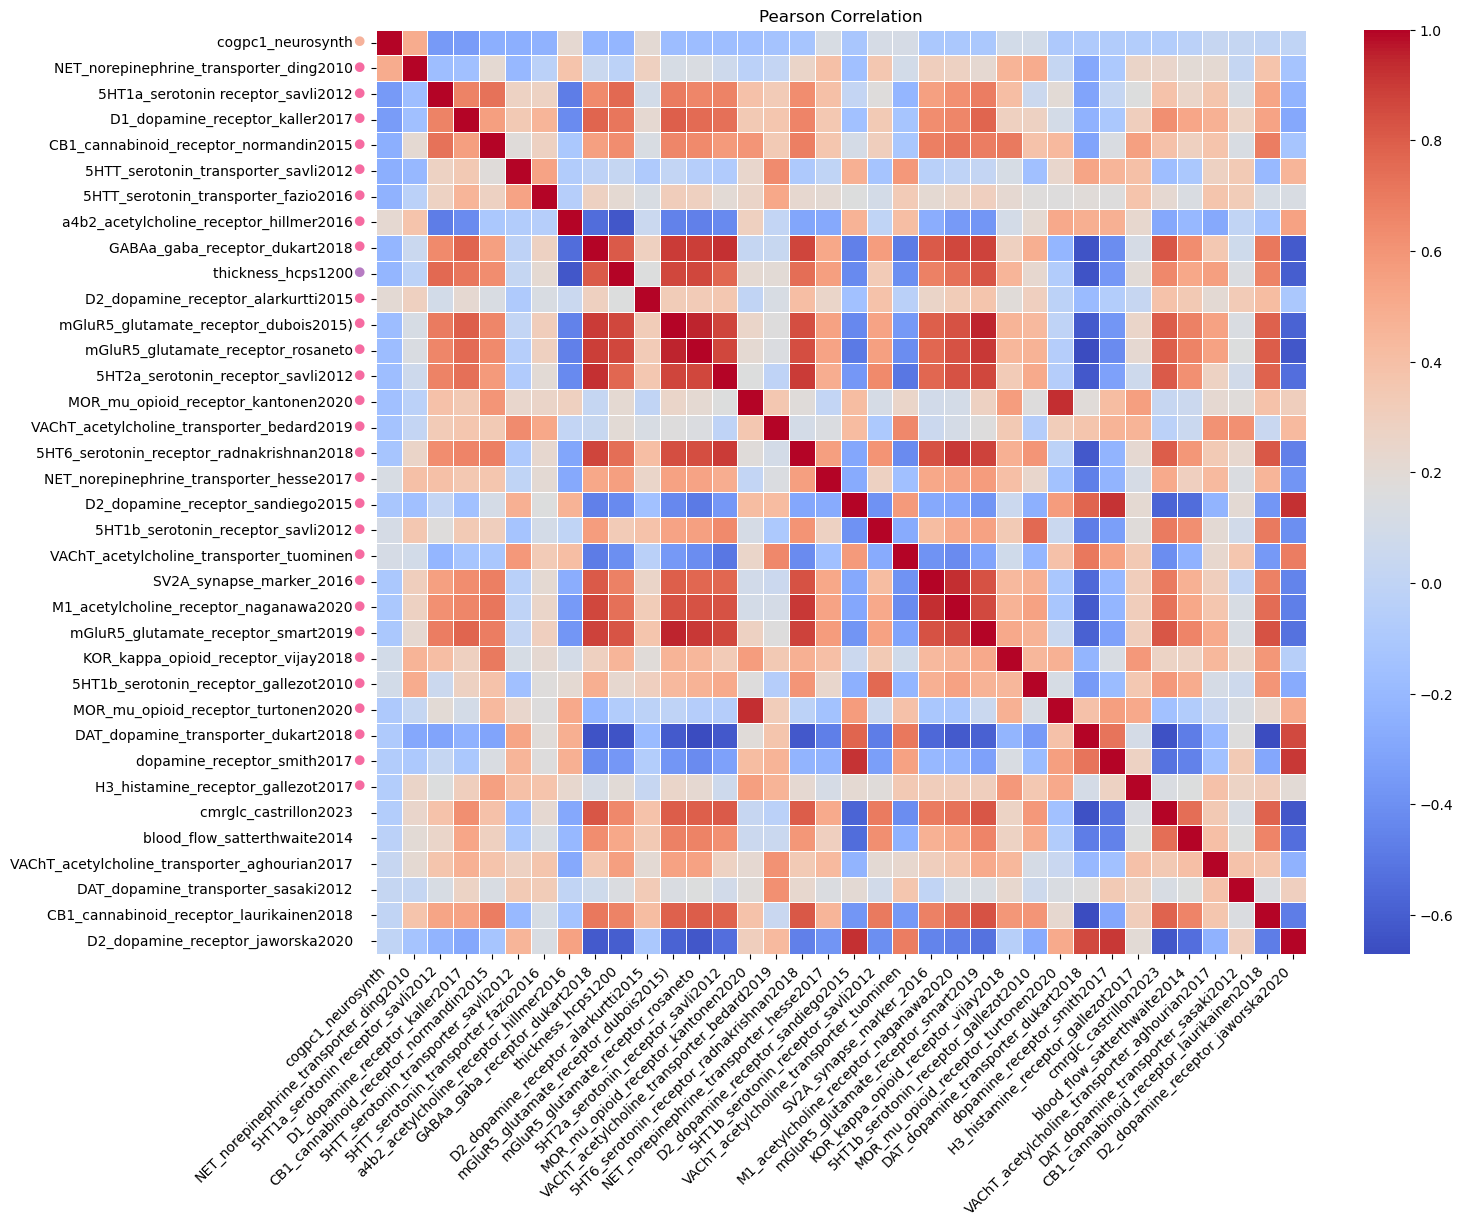

In [16]:
# Assuming df_brain is your DataFrame
corr_matrix = df_brain.corr()

# Calculate the absolute correlations with 'cogpc1_neurosynth' and sort them
sorted_columns = corr_matrix['cogpc1_neurosynth'].abs().sort_values(ascending=False).index

# Reorder the correlation matrix
sorted_corr_matrix = corr_matrix.loc[sorted_columns, sorted_columns]

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Pearson Correlation')

# Add a ball after the names on the y-axis
y_labels = [label + '   ' for label in sorted_corr_matrix.index]
plt.yticks(ticks=np.arange(len(y_labels)) + 0.5, labels=y_labels, rotation=0)
for i, label in enumerate(sorted_corr_matrix.index):
    color = df[df.name == label].color.values[0]
    plt.text(-0.3, i + 0.5, '⚫', color=color, va='center', ha='right', fontsize=15)

plt.show()

In [ ]:
sorted_corr_matrix

,cogpc1_neurosynth,fcgradient01_margulies2016,NET_norepinephrine_transporter_ding2010,sensory_association_sydnor2021,fcgradient07_margulies2016,5HT1a_serotonin receptor_savli2012,D1_dopamine_receptor_kaller2017,fcgradient04_margulies2016,CB1_cannabinoid_receptor_normandin2015,5HTT_serotonin_transporter_savli2012,...,fcgradient06_margulies2016,dopamine_receptor_smith2017,H3_histamine_receptor_gallezot2017,fcgradient09_margulies2016,blood_flow_satterthwaite2014,VAChT_acetylcholine_transporter_aghourian2017,DAT_dopamine_transporter_sasaki2012,myelinmap_hcps1200,CB1_cannabinoid_receptor_laurikainen2018,D2_dopamine_receptor_jaworska2020
cogpc1_neurosynth,1.000000,-0.659497,0.503727,-0.495338,-0.360190,-0.355494,-0.348887,-0.310076,-0.256259,-0.253224,...,0.076180,-0.072726,-0.069404,-0.037171,-0.030422,0.028852,0.027038,-0.015242,0.006016,-0.001284
fcgradient01_margulies2016,-0.659497,1.000000,-0.348598,0.824892,0.173988,0.288463,0.253255,-0.004336,0.320116,0.001961,...,-0.031071,0.152665,0.150844,0.130915,0.087543,-0.150110,-0.081274,-0.195832,0.245060,0.072390
NET_norepinephrine_transporter_ding2010,0.503727,-0.348598,1.000000,-0.238284,-0.169454,-0.173447,-0.159280,-0.143264,0.215221,-0.206263,...,0.036591,-0.098052,0.257014,0.141571,0.201947,0.215008,0.027178,0.114589,0.377201,-0.131182
sensory_association_sydnor2021,-0.495338,0.824892,-0.238284,1.000000,0.076883,0.446863,0.346280,-0.102928,0.527518,0.105536,...,-0.090050,0.292087,0.327348,0.172718,0.154036,-0.002628,0.067631,-0.251587,0.388581,0.165602
fcgradient07_margulies2016,-0.360190,0.173988,-0.169454,0.076883,1.000000,0.038667,0.163015,0.108209,-0.012246,0.178193,...,0.057920,-0.075377,0.110064,0.065761,0.107824,0.073965,-0.001612,0.035841,-0.065319,-0.030785
5HT1a_serotonin receptor_savli2012,-0.355494,0.288463,-0.173447,0.446863,0.038667,1.000000,0.673445,-0.124870,0.730377,0.281682,...,-0.150448,0.024060,0.163940,-0.068748,0.251475,0.371288,0.130444,0.403110,0.530324,-0.231597
D1_dopamine_receptor_kaller2017,-0.348887,0.253255,-0.159280,0.346280,0.163015,0.673445,1.000000,0.045263,0.560825,0.341330,...,-0.046827,-0.108247,0.301796,0.141119,0.527987,0.476675,0.270113,0.508328,0.538185,-0.288843
fcgradient04_margulies2016,-0.310076,-0.004336,-0.143264,-0.102928,0.108209,-0.124870,0.045263,1.000000,-0.086625,0.345889,...,-0.124685,0.055705,0.144815,0.331953,-0.047563,0.048695,-0.008354,-0.039686,-0.266706,0.111952
CB1_cannabinoid_receptor_normandin2015,-0.256259,0.320116,0.215221,0.527518,-0.012246,0.730377,0.560825,-0.086625,1.000000,0.179541,...,-0.042059,0.138810,0.550190,0.100506,0.291806,0.376850,0.135539,0.224119,0.690514,-0.125500
5HTT_serotonin_transporter_savli2012,-0.253224,0.001961,-0.206263,0.105536,0.178193,0.281682,0.341330,0.345889,0.179541,1.000000,...,-0.093959,0.454003,0.399315,0.021543,-0.108730,0.288653,0.340275,-0.165269,-0.196357,0.457142


In [ ]:
# prompt: count nan in percentage
nan_ration= df_brain.isnull().mean()
print(nan_ration)
df_brain.dropna(inplace=True)

thickness_hcps1200                               0.0
VAChT_acetylcholine_transporter_aghourian2017    0.0
D2_dopamine_receptor_alarkurtti2015              0.0
VAChT_acetylcholine_transporter_bedard2019       0.0
NET_norepinephrine_transporter_ding2010          0.0
mGluR5_glutamate_receptor_dubois2015)            0.0
GABAa_gaba_receptor_dukart2018                   0.0
DAT_dopamine_transporter_dukart2018              0.0
5HTT_serotonin_transporter_fazio2016             0.0
SV2A_synapse_marker_2016                         0.0
5HT1b_serotonin_receptor_gallezot2010            0.0
H3_histamine_receptor_gallezot2017               0.0
myelinmap_hcps1200                               0.0
NET_norepinephrine_transporter_hesse2017         0.0
a4b2_acetylcholine_receptor_hillmer2016          0.0
D2_dopamine_receptor_jaworska2020                0.0
D1_dopamine_receptor_kaller2017                  0.0
MOR_mu_opioid_receptor_kantonen2020              0.0
CB1_cannabinoid_receptor_laurikainen2018      

### General Model

In [ ]:
target = "cogpc1_neurosynth"

# Prepare data
X = df_brain.drop(target, axis=1)
y = df_brain[target]

In [ ]:
# Initialize LightGBM model
model = lgbm.LGBMRegressor()

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Cross-validation R² scores: {cv_scores}')
print(f'Mean CV R² score: {mean_cv_score}')
print(f'Standard Deviation of CV R² scores: {std_cv_score}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 51987, number of used features: 47
[LightGBM] [Info] Start training from score 0.000146
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 51987, number of used features: 47
[LightGBM] [Info] Start training from score 0.000481
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

### Explainability

In [ ]:
# Train the model on the entire dataset
model.fit(X, y)

# Calculate SHAP values
X_renamed = X.rename(columns=names_features)
explainer = shap.Explainer(model, X)
explanation = explainer(X, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 64984, number of used features: 47
[LightGBM] [Info] Start training from score 0.000403


100%|===================| 64890/64984 [06:30<00:00]       

In [ ]:
mean_array = np.mean(np.abs(explanation.values), axis=0)
result = pd.Series(mean_array, index=X.columns).reset_index().rename(columns={0:'shap'})
inverse_mapping_dict = {v: k for k, v in names_features_adjusted.items()}
result['desc_source'] = result['index'].map(inverse_mapping_dict)
result['group'] = result['desc_source'].map(group)
result['color'] = result['group'].map(colors)
result = result.sort_values(by=['shap'],ascending=True)

result

,index,shap,desc_source,group,color
45,KOR_kappa_opioid_receptor_vijay2018,0.000010,ly2795050_vijay2018,Neurotransmitter information (PET),#f66ba1
23,fcgradient05_margulies2016,0.000013,fcgradient05_margulies2016,Functional information (fMRI),#f6b29b
11,H3_histamine_receptor_gallezot2017,0.000013,gsk189254_gallezot2017,Neurotransmitter information (PET),#f66ba1
5,mGluR5_glutamate_receptor_dubois2015),0.000013,abp688_dubois2015,Neurotransmitter information (PET),#f66ba1
29,M1_acetylcholine_receptor_naganawa2020,0.000013,lsn3172176_naganawa2020,Neurotransmitter information (PET),#f66ba1
10,5HT1b_serotonin_receptor_gallezot2010,0.000018,p943_gallezot2010,Neurotransmitter information (PET),#f66ba1
13,NET_norepinephrine_transporter_hesse2017,0.000018,methylreboxetine_hesse2017,Neurotransmitter information (PET),#f66ba1
32,mGluR5_glutamate_receptor_rosaneto,0.000018,abp688_rosaneto,Neurotransmitter information (PET),#f66ba1
36,5HT2a_serotonin_receptor_savli2012,0.000018,altanserin_savli2012,Neurotransmitter information (PET),#f66ba1
40,mGluR5_glutamate_receptor_smart2019,0.000019,abp688_smart2019,Neurotransmitter information (PET),#f66ba1


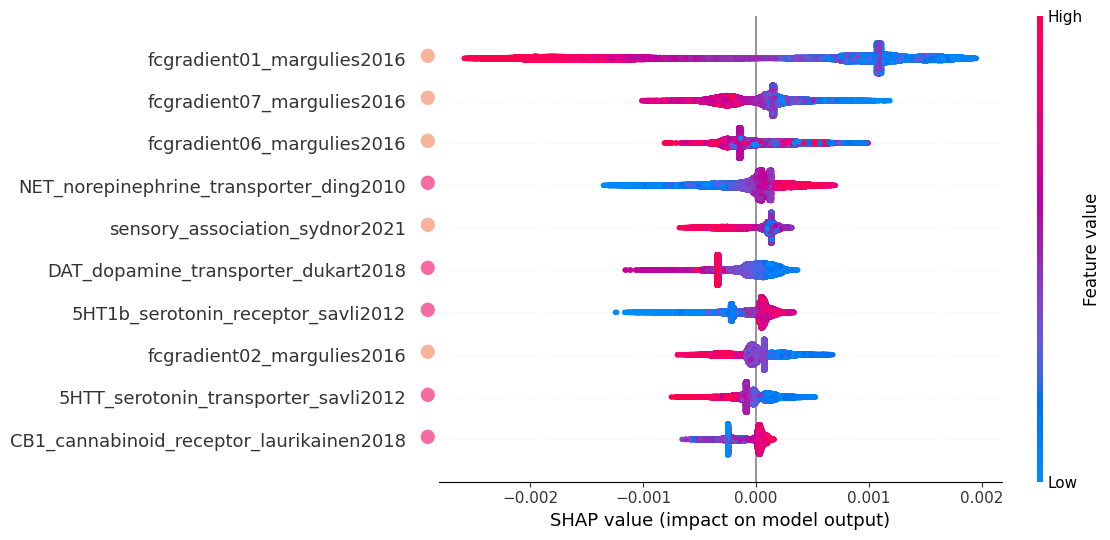

In [ ]:
# Generate the SHAP summary plot without displaying it
fig = shap.summary_plot(explanation, show=False, max_display=10)

for i, color in enumerate(result.color[-10:]):
  plt.text(-0.0028, i, '⚫', color=color, va='center', ha='right', fontsize=22)

w, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(h*3, h)
plt.show()

In [ ]:
#shap_interaction_values = explainer.shap_interaction_values(X)
#mean_shap = np.abs(shap_interaction_values).mean(0)*10000
#df_mean = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)
# times off diagonal by 2
#df_mean.where(df_mean.values == np.diagonal(df_mean),df_mean.values*2,inplace=True)
# display heatmap
#plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
#plt.title('Shap interaction mean')
#sns.set(font_scale=0.8)
#sns.heatmap(df_mean,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
#plt.xticks(rotation=45)
#plt.show()
# display shap summary plot
#shap.summary_plot(shap_interaction_values,
#                  features=np.array(X_renamed),
#                  feature_names =np.array(X_renamed.columns),
#                  max_display=12)

In [ ]:
X.columns

Index(['thickness_hcps1200', 'VAChT_acetylcholine_transporter_aghourian2017',
       'D2_dopamine_receptor_alarkurtti2015',
       'VAChT_acetylcholine_transporter_bedard2019',
       'NET_norepinephrine_transporter_ding2010',
       'mGluR5_glutamate_receptor_dubois2015)',
       'GABAa_gaba_receptor_dukart2018', 'DAT_dopamine_transporter_dukart2018',
       '5HTT_serotonin_transporter_fazio2016', 'SV2A_synapse_marker_2016',
       '5HT1b_serotonin_receptor_gallezot2010',
       'H3_histamine_receptor_gallezot2017', 'myelinmap_hcps1200',
       'NET_norepinephrine_transporter_hesse2017',
       'a4b2_acetylcholine_receptor_hillmer2016',
       'D2_dopamine_receptor_jaworska2020', 'D1_dopamine_receptor_kaller2017',
       'MOR_mu_opioid_receptor_kantonen2020',
       'CB1_cannabinoid_receptor_laurikainen2018',
       'fcgradient01_margulies2016', 'fcgradient02_margulies2016',
       'fcgradient03_margulies2016', 'fcgradient04_margulies2016',
       'fcgradient05_margulies2016', 'fcgrad

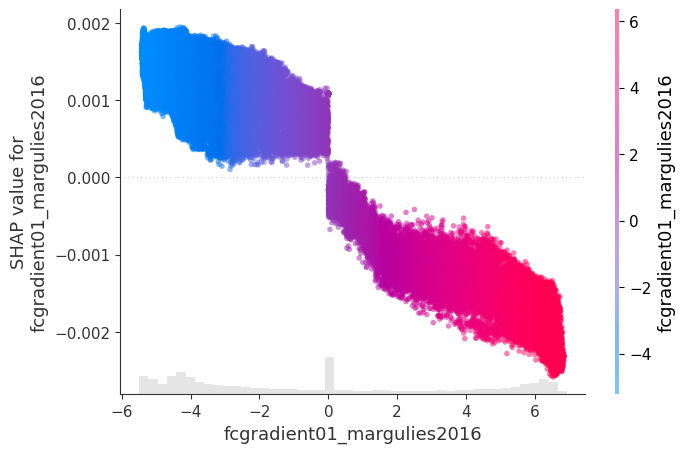

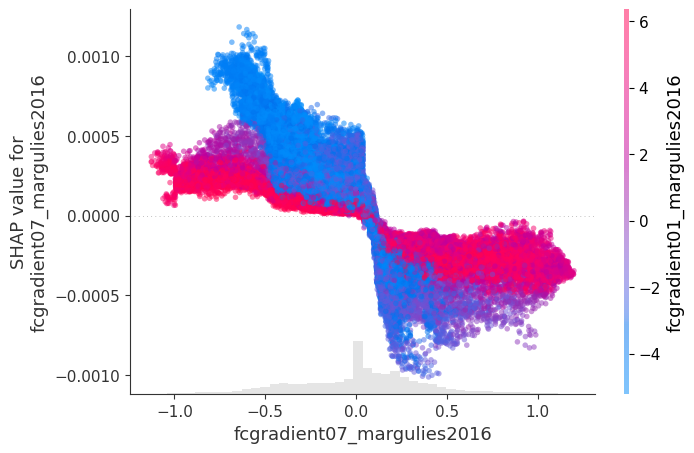

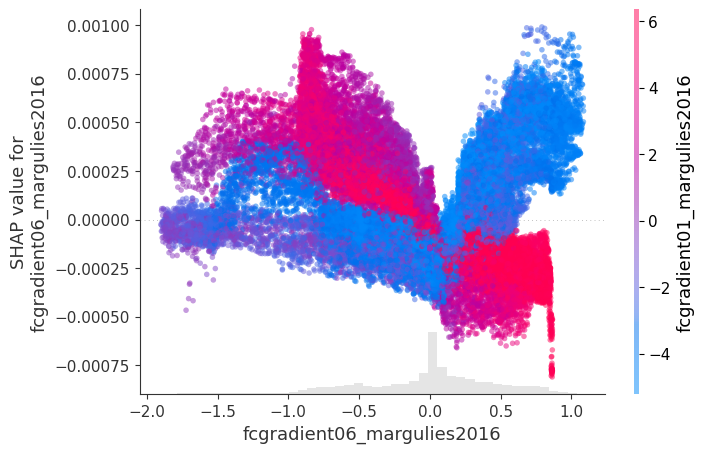

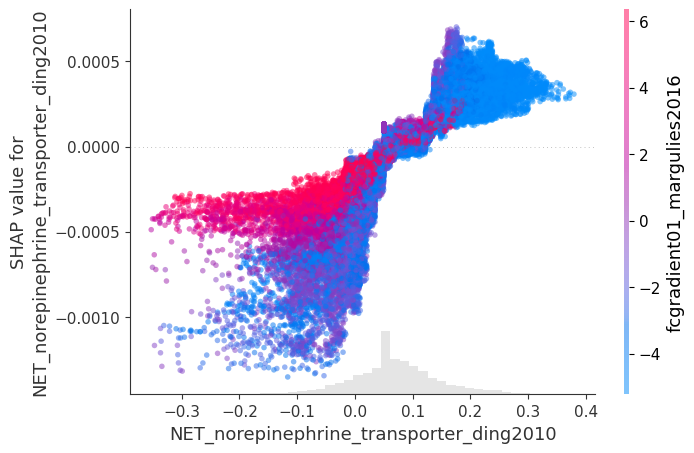

In [ ]:
shap.plots.scatter(explanation[:, 'fcgradient01_margulies2016'], color=explanation[:,'fcgradient01_margulies2016'], alpha = 0.5) #cmap=plt.cm.magma
shap.plots.scatter(explanation[:, 'fcgradient07_margulies2016'], color=explanation[:,'fcgradient01_margulies2016'], alpha = 0.5)
shap.plots.scatter(explanation[:, 'fcgradient06_margulies2016'], color=explanation[:,'fcgradient01_margulies2016'], alpha = 0.5)
shap.plots.scatter(explanation[:, 'NET_norepinephrine_transporter_ding2010'], color=explanation[:,'fcgradient01_margulies2016'], alpha = 0.5)

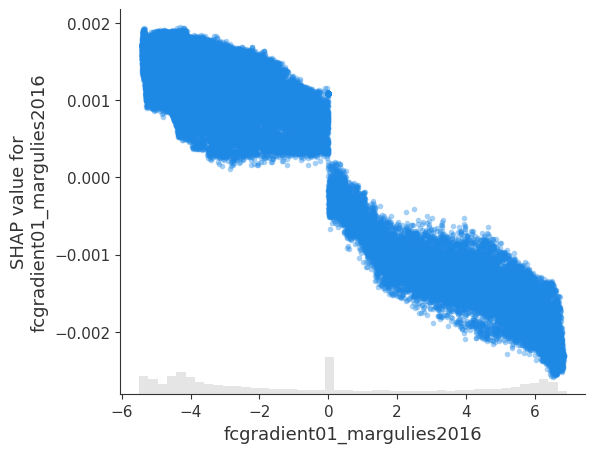

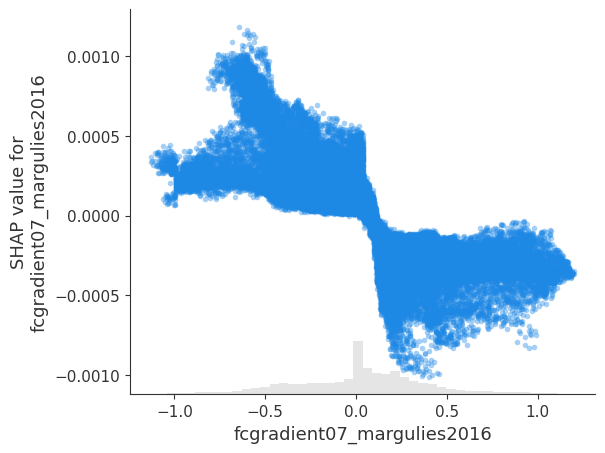

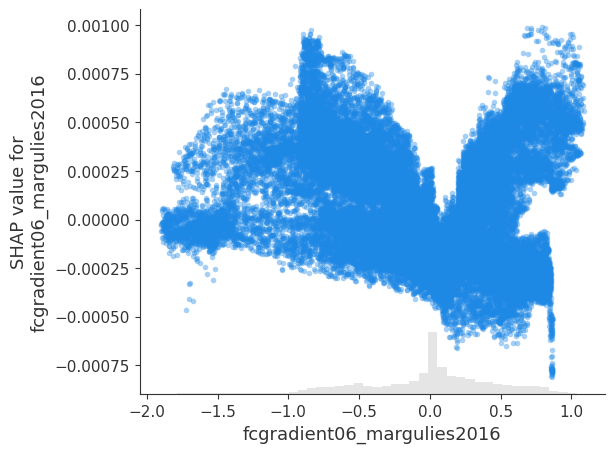

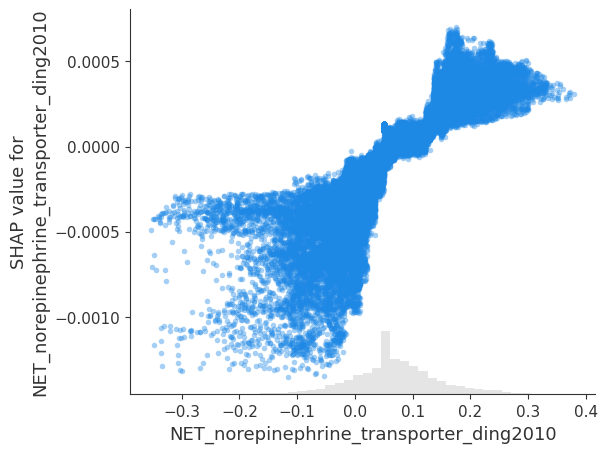

In [ ]:
shap.plots.scatter(explanation[:, 'fcgradient01_margulies2016'], alpha = 0.4)
shap.plots.scatter(explanation[:, 'fcgradient07_margulies2016'], alpha = 0.4)
shap.plots.scatter(explanation[:, 'fcgradient06_margulies2016'], alpha = 0.4)
shap.plots.scatter(explanation[:, 'NET_norepinephrine_transporter_ding2010'], alpha = 0.4)

### Sub Models

In [ ]:
target = "cogpc1_neurosynth"

# Prepare data
X = df_brain.drop(target, axis=1)
y = df_brain[target]

In [ ]:
df_dummy = df[df.name!=target].copy()
tags = {
          'General': df_dummy.dropna().name.to_list(),
          'ASL': df_dummy[df_dummy.ASL==1].dropna().name.to_list(),
          'MEG': df_dummy[df_dummy.MEG==1].dropna().name.to_list(),
          'MRI': df_dummy[df_dummy.MRI==1].dropna().name.to_list(),
          'Functional': df_dummy[df_dummy.fMRI==1].dropna().name.to_list(),
          'functional': df_dummy[df_dummy.functional==1].dropna().name.to_list(),
          'genetics': df_dummy[df_dummy.genetics==1].dropna().name.to_list(),
          'meta-analysis': df_dummy[df_dummy['meta-analysis']==1].dropna().name.to_list(),
          'metabolism': df_dummy[df_dummy.metabolism==1].dropna().name.to_list(),
          'Neurotransmitter': df_dummy[df_dummy.receptors==1].dropna().name.to_list(),
          'Structural': df_dummy[df_dummy.structural==1].dropna().name.to_list()
}
tags

{'General': ['VAChT_acetylcholine_transporter_aghourian2017',
  'D2_dopamine_receptor_alarkurtti2015',
  'VAChT_acetylcholine_transporter_bedard2019',
  'NET_norepinephrine_transporter_ding2010',
  'mGluR5_glutamate_receptor_dubois2015)',
  'GABAa_gaba_receptor_dukart2018',
  'DAT_dopamine_transporter_dukart2018',
  '5HTT_serotonin_transporter_fazio2016',
  'SV2A_synapse_marker_2016',
  '5HT1b_serotonin_receptor_gallezot2010',
  'H3_histamine_receptor_gallezot2017',
  'myelinmap_hcps1200',
  'thickness_hcps1200',
  'NET_norepinephrine_transporter_hesse2017',
  'a4b2_acetylcholine_receptor_hillmer2016',
  'D2_dopamine_receptor_jaworska2020',
  'D1_dopamine_receptor_kaller2017',
  'MOR_mu_opioid_receptor_kantonen2020',
  'CB1_cannabinoid_receptor_laurikainen2018',
  'fcgradient01_margulies2016',
  'fcgradient02_margulies2016',
  'fcgradient03_margulies2016',
  'fcgradient04_margulies2016',
  'fcgradient05_margulies2016',
  'fcgradient06_margulies2016',
  'fcgradient07_margulies2016',
  '

In [ ]:
results = {}

for key, value in tags.items():
  if value != []:

    # Initialize LightGBM model
    model = lgbm.LGBMRegressor()

    # Cross-validation
    cv_scores = cross_val_score(model, X[value], y, cv=5, scoring='r2')

    # Storage results in dictonary
    results[key] = (np.mean(cv_scores), np.std(cv_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 51987, number of used features: 47
[LightGBM] [Info] Start training from score 0.000146
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11985
[LightGBM] [Info] Number of data points in the train set: 51987, number of used features: 47
[LightGBM] [Info] Start training from score 0.000481
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

In [ ]:
results = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Category', 0:'Mean', 1:'Std'}).convert_dtypes()
results.loc[results['Mean'] < 0, 'Mean'] = -0.01
results

,Category,Mean,Std
0,General,0.818433,0.045225
1,ASL,-0.01,0.263622
2,MRI,0.790426,0.057865
3,Functional,0.754723,0.069042
4,functional,0.762242,0.071647
5,Neurotransmitter,0.668039,0.071466
6,Structural,0.170927,0.157452


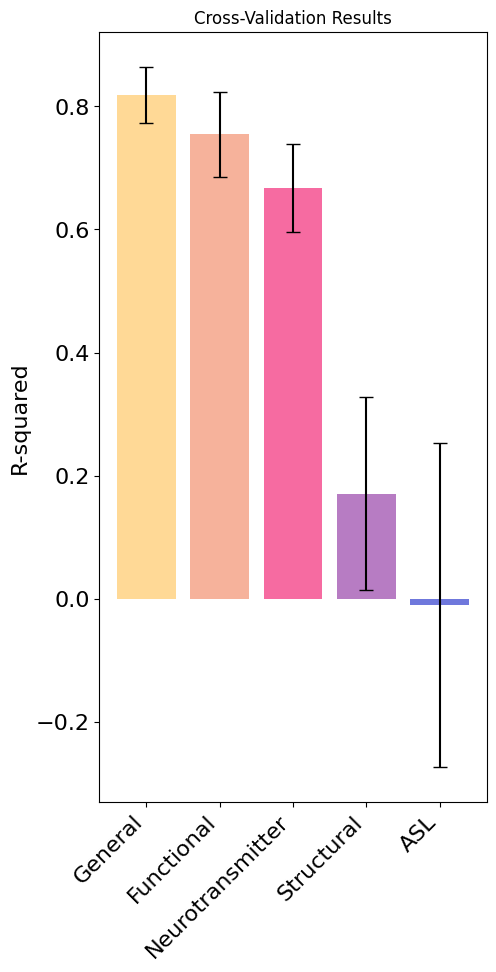

In [ ]:
# Plotting the bar graph
results_clean = results.loc[[0,3,5,6,1]].sort_values(by='Mean', ascending=False)
plt.figure(figsize=(5, 10))
plt.bar(results_clean.Category, results_clean.Mean, yerr=results_clean.Std, capsize=5,
        color=['#ffd996', '#f6b29b', '#f66ba1', '#b77cc3', '#6f78dc'])
plt.xticks(rotation=45, fontsize=16, ha='right')
plt.yticks( fontsize=16)
plt.ylabel('R-squared', fontsize=16)
plt.ylabel('R-squared')
plt.title('Cross-Validation Results')
plt.show()

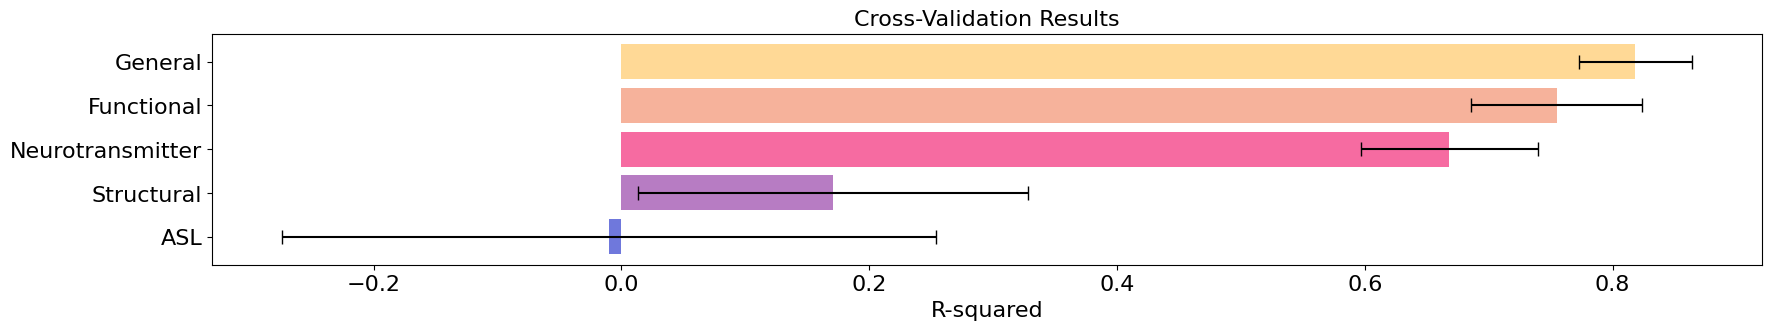

In [ ]:
# Plotting the horizontal bar graph
results_clean = results.loc[[0,1,3,5,6]].sort_values(by='Mean', ascending=False)
plt.figure(figsize=(20, 3))

plt.barh(results_clean.Category, results_clean.Mean, xerr=results_clean.Std, capsize=5,
         color=['#ffd996', '#f6b29b', '#f66ba1', '#b77cc3', '#6f78dc'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('R-squared', fontsize=16)  # Change ylabel to xlabel for horizontal bars
plt.title('Cross-Validation Results', fontsize=16)
plt.gca().invert_yaxis()  # Optional: invert to keep the highest Mean on top
plt.show()


### Atlas

In [ ]:
# Fetch the Schaefer atlas with specific parameters
atlas = nilearn.datasets.fetch_atlas_schaefer_2018(resolution_mm=2)

# Use the fetched atlas in the resample_images function
array_base_atlas, array_resampled_atlas = resample_images(
    src=base_atlas, 
    trg=atlas['maps'],
    src_space=base_space, 
    trg_space=space,
    method='linear', 
    resampling='transform_to_src'
)

In [27]:
import nibabel as nib
import numpy as np
from scipy.sparse.csgraph import dijkstra

# Load the cortical surface data
surf_path = '/home/tamires/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-L_feature.func.gii'
surf = nib.load(surf_path)
coords = surf.darrays[0].data
faces = surf.darrays[1].data

# Compute the adjacency matrix
n_vertices = coords.shape[0]
adj_matrix = np.zeros((n_vertices, n_vertices))

for face in faces:
    for i in range(3):
        for j in range(i + 1, 3):
            vi, vj = face[i], face[j]
            dist = np.linalg.norm(coords[vi] - coords[vj])
            adj_matrix[vi, vj] = dist
            adj_matrix[vj, vi] = dist

# Compute the geodesic distance using Dijkstra's algorithm
geodesic_distances = dijkstra(adj_matrix, directed=False)

# Save or visualize the geodesic distance
np.save('geodesic_distances.npy', geodesic_distances)

IndexError: list index out of range

In [28]:
base_full_desc = 'MRI cortical thickness from the Human Connectome Project S1200 release'
base_source = 'hcps1200'
base_desc = 'thickness'
base_space = 'fsLR'
base_res_den = '32k'

#atasets.fetch_annotation(source=base_source, desc=base_desc)

In [22]:
dkt_atlas

In [16]:
import nibabel as nib
import nilearn 

# Load the fsLR space data
standard_space = ['/home/tamires/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-L_feature.func.gii',
                  '/home/tamires/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-R_feature.func.gii']
fslr_data_L = nib.load(standard_space[0])
fslr_data_R = nib.load(standard_space[1])

# Load the DKT atlas
dkt_atlas = nilearn.datasets.load_mni152_template(resolution=2)

# Resample the atlas to match the fsLR space with 32k vertices
resampled_atlas_L = nilearn.surface.vol_to_surf(dkt_atlas, standard_space[0])
resampled_atlas_R = nilearn.surface.vol_to_surf(dkt_atlas, fslr_data_R)

# Save the resampled atlas
nib.save(resampled_atlas_L, 'resampled_dkt_atlas_L.gii')
nib.save(resampled_atlas_R, 'resampled_dkt_atlas_R.gii')

ValueError: The surf_mesh input is not recognized. Valid Freesurfer surface mesh inputs are: '.orig', '.pial', '.sphere', '.white', '.infla'.You provided input which have no NIFTI_INTENT_POINTSET or of empty value=[]

In [25]:
dkt_atlas = nilearn.datasets.fetch_atlas_destrieux_2009()['maps']
dkt_atlas

'/home/tamires/nilearn_data/destrieux_2009/destrieux2009_rois_lateralized.nii.gz'

In [39]:
import nibabel as nib
import nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import resample_to_img

# Load the image
image_path = '/home/tamires/neuromaps-data/annotations/hcps1200/thickness/fsLR/source-hcps1200_desc-thickness_space-fsLR_den-32k_hemi-L_feature.func.gii'
image = nib.load(image_path)

# Load the atlas data
dkt_atlas = fetch_atlas_destrieux_2009()
atlas = nib.load(dkt_atlas['maps'])

# Resample the atlas to the image space
resampled_atlas = resample_to_img(atlas, image, interpolation='nearest')

# Get the data from the image and resampled atlas
image_data = image.darrays[0].data
resampled_atlas_data = resampled_atlas.get_fdata()

# Flatten the resampled atlas data to match the image data shape
resampled_atlas_data_flat = resampled_atlas_data.flatten()


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
<nibabel.gifti.gif...

In [19]:
import nilearn.plotting as plotting
from nilearn import datasets

# Load the brain atlas data
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)

# Set the space and resolution density
base_space = 'fsLR'
base_res_den = '32k'

#atlas
nib.load(atlas['maps'])

### References

In [ ]:
data

{'annotations': [{'annot': {'source': 'abagen',
    'desc': 'genepc1',
    'space': 'fsaverage',
    'den': '10k'},
   'full_desc': 'PC1 of genes in the Allen Human Brain Atlas',
   'refs': {'primary': [{'citation': 'Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.',
      'bibkey': 'hawrylycz2012nature'},
     {'citation': 'Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.',
      'bibkey': 'markello2021elife'}],
    'secondary': [{'citation': '', 'bibkey': ''}]},
   'demographics': {'N': 6, 'age': '24-55'}},
  {'annot': {'source': 'aghourian2017',
    'desc': 'feobv',
    'space': '

In [ ]:
result.rename(columns={'index':'name'}, inplace=True)
result

,name,shap,desc_source,group,color
45,KOR_kappa_opioid_receptor_vijay2018,0.000010,ly2795050_vijay2018,receptors,#f66ba1
23,fcgradient05_margulies2016,0.000013,fcgradient05_margulies2016,fMRI,#f6b29b
11,H3_histamine_receptor_gallezot2017,0.000013,gsk189254_gallezot2017,receptors,#f66ba1
5,mGluR5_glutamate_receptor_dubois2015),0.000013,abp688_dubois2015,receptors,#f66ba1
29,M1_acetylcholine_receptor_naganawa2020,0.000013,lsn3172176_naganawa2020,receptors,#f66ba1
10,5HT1b_serotonin_receptor_gallezot2010,0.000018,p943_gallezot2010,receptors,#f66ba1
13,NET_norepinephrine_transporter_hesse2017,0.000018,methylreboxetine_hesse2017,receptors,#f66ba1
32,mGluR5_glutamate_receptor_rosaneto,0.000018,abp688_rosaneto,receptors,#f66ba1
36,5HT2a_serotonin_receptor_savli2012,0.000018,altanserin_savli2012,receptors,#f66ba1
40,mGluR5_glutamate_receptor_smart2019,0.000019,abp688_smart2019,receptors,#f66ba1


In [ ]:
import pandas as pd

def get_primary_references(data, result):
    items = result.desc_source.to_list()
    references = {}
    for item in items:
        desc, source = item.rsplit('_', 1)
        for annotation in data['annotations']:
            if annotation['annot']['desc'] == desc and annotation['annot']['source'] == source:
                primary_refs = annotation['refs'].get('primary', [])
                if primary_refs:
                    # Store the citation as a list to avoid the ValueError
                    references[item] = ([primary_refs[0]['citation']], result.group, result.name)
                break
    return references

# Get primary references
primary_references = pd.DataFrame(get_primary_references(data, result)).T.sort_index()
primary_references

,0,1,2
SAaxis_sydnor2021,"[Valerie J Sydnor, Bart Larsen, Danielle S Bassett, Aaron Alexander-Bloch, Damien A Fair, Conor Liston, Allyson P Mackey, Michael P Milham, Adam Pines, David R Roalf, and others. Neurodevelopment of the association cortices: patterns, mechanisms, and implications for psychopathology. Neuron, 109(18):2820–2846, 2021.]","45 receptors 23 fMRI 11 receptors 5 receptors 29 receptors 10 receptors 13 receptors 32 receptors 36 receptors 40 receptors 27 fMRI 16 receptors 33 receptors 1 receptors 3 receptors 2 receptors 34 receptors 14 receptors 31 receptors 17 receptors 41 receptors 28 fMRI 39 receptors 46 structural 44 receptors 9 receptors 12 structural 35 ASL 8 receptors 15 receptors 0 structural 22 fMRI 21 fMRI 6 receptors 26 fMRI 43 receptors 30 receptors 18 receptors 37 receptors 20 fMRI 38 receptors 7 receptors 42 receptors 4 receptors 24 fMRI 25 fMRI 19 fMRI Name: group, dtype: object","45 KOR_kappa_opioid_receptor_vijay2018 23 fcgradient05_margulies2016 11 H3_histamine_receptor_gallezot2017 5 mGluR5_glutamate_receptor_dubois2015) 29 M1_acetylcholine_receptor_naganawa2020 10 5HT1b_serotonin_receptor_gallezot2010 13 NET_norepinephrine_transporter_hesse2017 32 mGluR5_glutamate_receptor_rosaneto 36 5HT2a_serotonin_receptor_savli2012 40 mGluR5_glutamate_receptor_smart2019 27 fcgradient09_margulies2016 16 D1_dopamine_receptor_kaller2017 33 D2_dopamine_receptor_sandiego2015 1 VAChT_acetylcholine_transporter_aghourian2017 3 VAChT_acetylcholine_transporter_bedard2019 2 D2_dopamine_receptor_alarkurtti2015 34 DAT_dopamine_transporter_sasaki2012 14 a4b2_acetylcholine_receptor_hillmer2016 31 5HT6_serotonin_receptor_radnakrishnan2018 17 MOR_mu_opioid_receptor_kantonen2020 41 dopamine_receptor_smith2017 28 fcgradient10_margulies2016 39 5HT1a_serotonin receptor_savli2012 46 evolutionary_cortical_expansion_xu2020 44 MOR_mu_opioid_receptor_turtonen2020 9 SV2A_synapse_marker_2016 12 myelinmap_hcps1200 35 blood_flow_satterthwaite2014 8 5HTT_serotonin_transporter_fazio2016 15 D2_dopamine_receptor_jaworska2020 0 thickness_hcps1200 22 fcgradient04_margulies2016 21 fcgradient03_margulies2016 6 GABAa_gaba_receptor_dukart2018 26 fcgradient08_margulies2016 43 VAChT_acetylcholine_transporter_tuominen 30 CB1_cannabinoid_receptor_normandin2015 18 CB1_cannabinoid_receptor_laurikainen2018 37 5HTT_serotonin_transporter_savli2012 20 fcgradient02_margulies2016 38 5HT1b_serotonin_receptor_savli2012 7 DAT_dopamine_transporter_dukart2018 42 D2_sensory_association_sydnor2021 4 NET_norepinephrine_transporter_ding2010 24 fcgradient06_margulies2016 25 fcgradient07_margulies2016 19 fcgradient01_margulies2016 Name: name, dtype: object"
abp688_dubois2015,"[Jonathan M DuBois, Olivier G Rousset, Jared Rowley, Manuel Porras-Betancourt, Andrew J Reader, Aurelie Labbe, Gassan Massarweh, Jean-Paul Soucy, Pedro Rosa-Neto, and Eliane Kobayashi. Characterization of age/sex and the regional distribution of mglur5 availability in the healthy human brain measured by high-resolution [11 c] abp688 pet. European journal of nuclear medicine and molecular imaging, 43(1):152–162, 2016.]","45 receptors 23 fMRI 11 receptors 5 receptors 29 receptors 10 receptors 13 receptors 32 receptors 36 receptors 40 receptors 27 fMRI 16 receptors 33 receptors 1 receptors 3 receptors 2 receptors 34 receptors 14 receptors 31 receptors 17 receptors 41 receptors 28 fMRI 39 receptors 46 structural 44 receptors 9 receptors 12 structural 35 ASL 8 receptors 15 receptors 0 structural 22 fMRI 21 fMRI 6 receptors 26 fMRI 43 receptors 30 receptors 18 receptors 37 receptors 20 fMRI 38 receptors 7 receptors 42 receptors 4 receptors 24 fMRI 25 fMRI 19 fMRI Name: group, dtype: object","45 KOR_kappa_opioid_receptor_vijay2018 23 fcgradient05_margulies2016 11 H3_histamine_receptor_gallezot2017 5 mGluR5_glutamate_receptor_dubois2015) 29 M1_acetylcholine_receptor_naganawa2020 10 5HT1b_serotonin_receptor_gallezot2010 13 NET_norepinephrine_transporter_hesse2017 32 mGluR5_glutamate_receptor_rosaneto 36 